In [2]:
from imp import reload
import sys
print(sys.version)
# import rpy2
import os
import os.path
import glob
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# Use Type 1 fonts in plots.
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm

3.7.5 (default, Nov  1 2019, 02:16:23) 
[Clang 11.0.0 (clang-1100.0.33.8)]


# Plotting the results of the experiments in the paper 
## Which value of $r_1$ (ratio_samples_learn) and $r_2$ (weight_samples_learn) is the best for each instance?

The learning rate $\rho$ (uBorda parameter) is **not** set manually. Instead, we use these two parameters to obtain a more interpretable setting: The value of $\rho$ is set at each iteration and depends on the set of function evaluations $F$. Parameter $\rho$ is set such that the largest $r_1$\% of the mass of the weights is concentrated in the best $r_2$\% of the solutions in $S$, i.e., 

$$
r_1 \sum_{\sigma\in S}\rho^{f(\sigma)} =  \sum_{\sigma\in S'}\rho^{f(\sigma)} \text{where} |S'| = r_2|S| \land \forall \sigma'\in S', \sigma\in S\setminus S' : f(\sigma')\geq f(\sigma)
$$


Therefore, for each instance, we plot the mean of the best fitnesses over 10 repetitions as a function of $r_1$ and $r_2$. Since we are minimizing, the lower the better. 

Overall, the values ($r_1, r_2$)=(.1,.9) have good performance, we will use this configuration for the rest of the experimental section. 

For the LOP instances (synthetic and real) the best fitness function changes smoothly when we change the parameters
For the QAP and PFSP this does not happen, meaning that the convergence to the optimal is not smooth

The following two cells perform the experiments, in particular:
- the first one run the whole combination of parameters (beware that this takes long because they are lots of executions) and we do not recomment to run here and
- the second one processes the results and generates the plots

lop/IO/N-t59d11xx


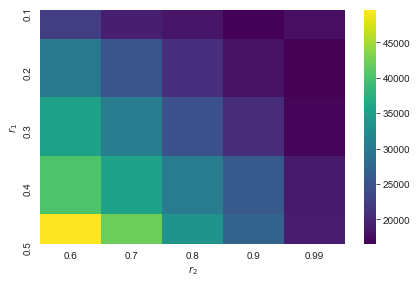

lop/SGB/N-sgb75.02


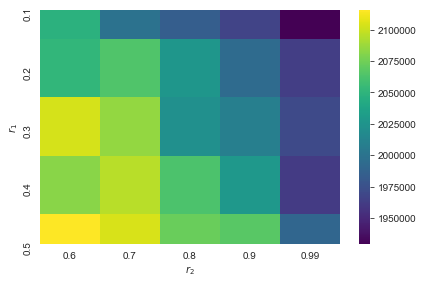

pfsp/rec13.txt


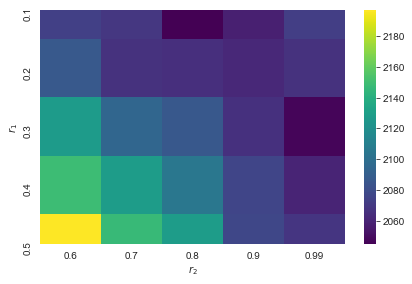

pfsp/rec19.txt


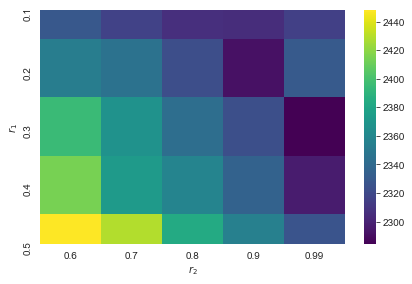

In [36]:
df = pd.read_csv('results/m400-er0/tuning.csv', sep=';')
df['Fitness'] = df['fitness'].astype(float)
df = df.drop('fitness',axis=1)
for insta in ['lop/IO/N-t59d11xx', 'lop/SGB/N-sgb75.02', 'pfsp/rec13.txt','pfsp/rec19.txt' ]: #df.instance.drop_duplicates():
  print(insta)
  aux = df[df.instance==insta]
  sns.heatmap(aux.pivot_table(index='r_1', columns='r_2', values='Fitness'), cmap="viridis")
  plt.tight_layout()
  plt.xlabel(r'$r_2$')
  plt.ylabel(r'$r_1$')
  plt.savefig('img/heatmap_' + insta.replace('/','_').replace('.','_') + '.pdf')
  plt.show()

In [42]:
df = df[['instance', 'seed', 'umm_m_ini', 'budgetMM', 'r_1', 'r_2', 'budget',
       'eval_ranks',      'Fitness']]

In [43]:
gr = df.groupby(['instance','r_1','r_2']).mean()#.reset_index()
gr = gr.groupby('instance').rank()#.to_csv('ranks.csv')
gr.groupby(['r_1','r_2']).mean().reset_index().sort_values(by='Fitness')

,r_1,r_2,seed,umm_m_ini,budgetMM,budget,eval_ranks,Fitness
3,0.1,0.90,13.0,13.0,13.0,13.0,13.0,4.00
14,0.3,0.99,13.0,13.0,13.0,13.0,13.0,4.30
2,0.1,0.80,13.0,13.0,13.0,13.0,13.0,4.90
19,0.4,0.99,13.0,13.0,13.0,13.0,13.0,5.00
4,0.1,0.99,13.0,13.0,13.0,13.0,13.0,5.50
9,0.2,0.99,13.0,13.0,13.0,13.0,13.0,5.80
8,0.2,0.90,13.0,13.0,13.0,13.0,13.0,6.70
24,0.5,0.99,13.0,13.0,13.0,13.0,13.0,8.10
1,0.1,0.70,13.0,13.0,13.0,13.0,13.0,8.50
7,0.2,0.80,13.0,13.0,13.0,13.0,13.0,10.10


# Real datasets (LOP, PFSP)
In the following lines we load the results of the real dataset for CEGO and UMM, plot the results and make the comparison table

In [13]:
dfbest = pd.read_csv('best_fitness_selected.csv',sep=';')
def get_opt(instpath):
  instance_name = instpath.split('/')[-1].replace('.dat','').replace('.txt','')
  sol = dfbest[dfbest.instance_name==instance_name]#.best_known_subdiagonal.values
  if len(sol)!=1: 
    print("No opt value")
    return np.nan
  if sol.best_known_subdiagonal.iloc[0] is not None: return sol.best_known_subdiagonal.iloc[0]
  return sol.best_known.iloc[0]
    

  # Compare synthetic data in the same plot.
# Compare the convergence to lowest fitness funtion values by the two solvers
lis = []
for filename in glob.glob("./results/**/*.pkl.*z", recursive=True): lis.append(pd.read_pickle(filename))
# for filename in glob.glob("./results-er*/*/*/*.pkl.*z"): lis.append(pd.read_pickle(filename))
dfreal = pd.concat(lis, sort = True)
dfreal['Uniformity'] = dfreal.instance.str.extract(r'phi=(.+)$').astype(float)
assert((dfreal.groupby(['Solver', 'instance'])['seed'].nunique() == 10).all())
dfreal


,Distance,Fitness,Function evaluations,Problem,Solver,budget,budgetGA,budgetMM,eval_ranks,instance,m_ini,phi_estim,phi_sample,ratio_samples_learn,rho,run_time,seed,weight_mass_learn,x,Uniformity
0,NaN,88903.0,1,LOP,UMM,200,NaN,1.0,0,lop/IO/N-t59d11xx,10,NaN,NaN,0.1,NaN,55.797884,2,0.9,"[29, 33, 14, 9, 42, 0, 2, 16, 13, 39, 23, 41, ...",NaN
1,NaN,97416.0,2,LOP,UMM,200,NaN,1.0,0,lop/IO/N-t59d11xx,10,NaN,NaN,0.1,NaN,55.797884,2,0.9,"[24, 29, 25, 30, 7, 3, 38, 16, 35, 14, 20, 21,...",NaN
2,NaN,76681.0,3,LOP,UMM,200,NaN,1.0,0,lop/IO/N-t59d11xx,10,NaN,NaN,0.1,NaN,55.797884,2,0.9,"[5, 3, 42, 34, 18, 24, 23, 31, 25, 12, 37, 36,...",NaN
3,NaN,55697.0,4,LOP,UMM,200,NaN,1.0,0,lop/IO/N-t59d11xx,10,NaN,NaN,0.1,NaN,55.797884,2,0.9,"[12, 23, 43, 25, 35, 13, 36, 20, 18, 40, 26, 3...",NaN
4,NaN,80883.0,5,LOP,UMM,200,NaN,1.0,0,lop/IO/N-t59d11xx,10,NaN,NaN,0.1,NaN,55.797884,2,0.9,"[21, 9, 34, 10, 13, 37, 11, 23, 1, 28, 41, 0, ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,2518.0,96,PFSP,UMM,100,NaN,10.0,0,pfsp/rec19.txt,10,0.481209,0.21875,0.1,2.182787e-11,35.987877,4,0.9,"[1, 8, 7, 6, 17, 11, 3, 16, 29, 4, 23, 13, 28,...",NaN
96,NaN,2581.0,97,PFSP,UMM,100,NaN,10.0,0,pfsp/rec19.txt,10,0.477837,0.18750,0.1,1.455192e-11,35.987877,4,0.9,"[0, 7, 8, 4, 15, 11, 3, 16, 28, 5, 23, 14, 29,...",NaN
97,NaN,2541.0,98,PFSP,UMM,100,NaN,10.0,0,pfsp/rec19.txt,10,0.477824,0.15625,0.1,1.455192e-11,35.987877,4,0.9,"[0, 7, 8, 5, 16, 11, 3, 17, 28, 4, 19, 12, 29,...",NaN
98,NaN,2559.0,99,PFSP,UMM,100,NaN,10.0,0,pfsp/rec19.txt,10,0.477638,0.12500,0.1,1.455192e-11,35.987877,4,0.9,"[0, 7, 8, 5, 18, 11, 3, 16, 27, 4, 23, 13, 29,...",NaN


## Plot results
Plot the fitness along iterataion of the isntances in the paper, LOP and PFSP

instance:  lop/IO/N-t59d11xx
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       1800
UMM_400    0           400       4000
dtype: int64
optimum:  9000.0
Saving to img/fitness_lop_IO_N-t59d11xx.pdf


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


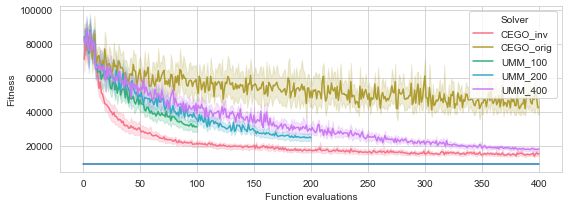

instance:  lop/IO/N-t59b11xx
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       2000
UMM_400    0           400       4000
dtype: int64
optimum:  93140.0
Saving to img/fitness_lop_IO_N-t59b11xx.pdf


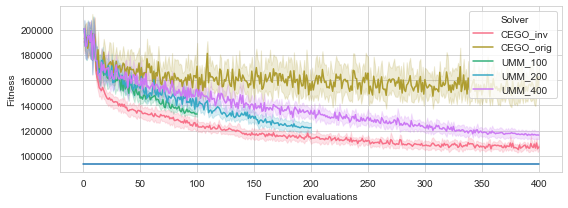

instance:  lop/SGB/N-sgb75.01
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       2000
UMM_400    0           400       4000
dtype: int64
optimum:  1632977.0
Saving to img/fitness_lop_SGB_N-sgb75_01.pdf


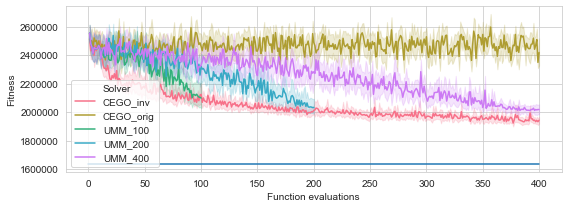

instance:  lop/SGB/N-sgb75.02
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       2000
UMM_400    0           400       4000
dtype: int64
optimum:  1613619.0
Saving to img/fitness_lop_SGB_N-sgb75_02.pdf


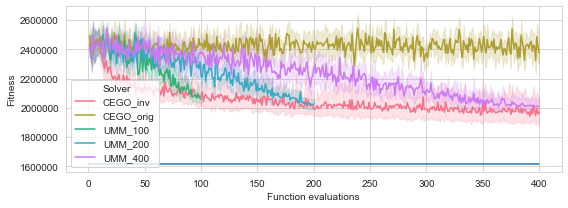

instance:  lop/RandB/N-p40-02
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       2000
UMM_400    0           400       4000
dtype: int64
optimum:  10683.0
Saving to img/fitness_lop_RandB_N-p40-02.pdf


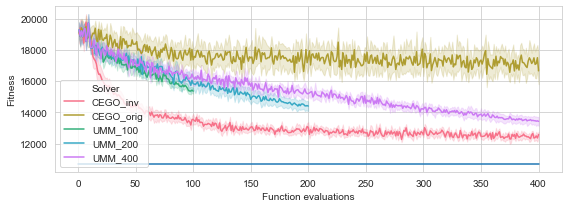

instance:  lop/RandB/N-p50-02
Solver    eval_ranks  budget
CEGO_inv  0           400       4000
UMM_100   0           100       1000
UMM_200   0           200       2000
UMM_400   0           400       4000
dtype: int64
optimum:  17269.0
Saving to img/fitness_lop_RandB_N-p50-02.pdf


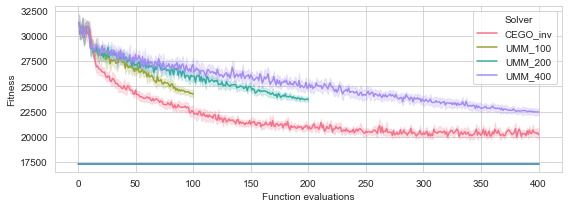

instance:  lop/RandB/N-p50-01
Solver    eval_ranks  budget
CEGO_inv  0           400       4000
UMM_100   0           100       1000
UMM_200   0           200       2000
UMM_400   0           400       4000
dtype: int64
optimum:  16673.0
Saving to img/fitness_lop_RandB_N-p50-01.pdf


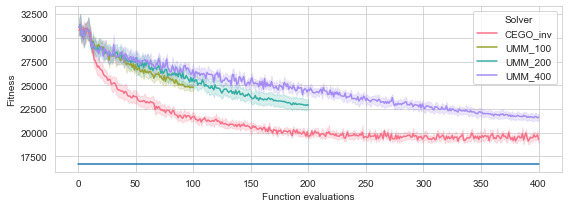

instance:  lop/RandB/N-p40-01
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       2000
UMM_400    0           400       4000
dtype: int64
optimum:  9663.0
Saving to img/fitness_lop_RandB_N-p40-01.pdf


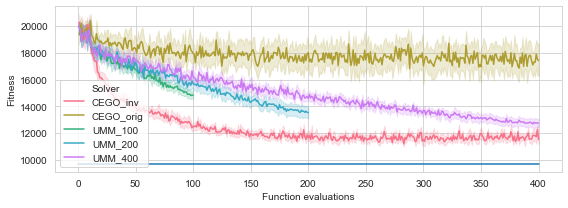

instance:  pfsp/rec13.txt
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       2000
UMM_400    0           400       4000
dtype: int64
optimum:  nan
Saving to img/fitness_pfsp_rec13_txt.pdf


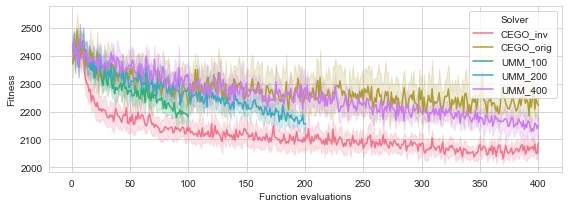

instance:  pfsp/rec05.txt
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       2000
UMM_400    0           400       4000
dtype: int64
optimum:  nan
Saving to img/fitness_pfsp_rec05_txt.pdf


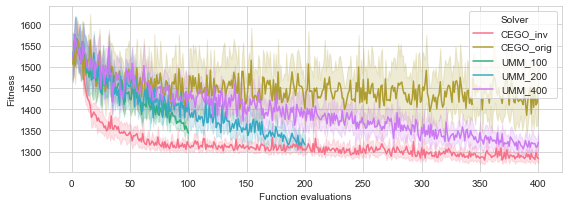

instance:  pfsp/rec31.txt
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       2000
UMM_400    0           400       4000
dtype: int64
optimum:  nan
Saving to img/fitness_pfsp_rec31_txt.pdf


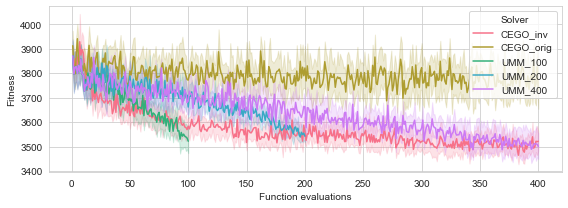

instance:  pfsp/rec19.txt
Solver     eval_ranks  budget
CEGO_inv   0           400       4000
CEGO_orig  1           400       4000
UMM_100    0           100       1000
UMM_200    0           200       2000
UMM_400    0           400       4000
dtype: int64
optimum:  nan
Saving to img/fitness_pfsp_rec19_txt.pdf


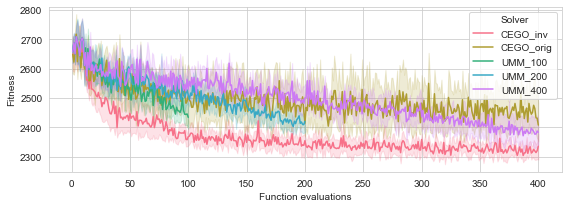

In [3]:
mask = (dfreal.budgetMM != 10)

sel_insts = ['lop/IO/N-t59d11xx' ,'lop/IO/N-t59b11xx' ,'lop/SGB/N-sgb75.01' ,'lop/SGB/N-sgb75.02' ,'lop/RandB/N-p40-02' ,'lop/RandB/N-p50-02', 'lop/RandB/N-p50-01' ,'lop/RandB/N-p40-01' ,'pfsp/rec13.txt', 'pfsp/rec05.txt', 'pfsp/rec31.txt', 'pfsp/rec19.txt']

# print(sel_insts)
for inst in sel_insts:
  df = dfreal[(mask) & (dfreal.instance.str.contains(inst))].copy() # & dfreal.instance.str.contains(inst)
  df.loc[(df.Solver=='CEGO')&(df.eval_ranks==1),'Solver'] = 'CEGO_orig'
  df.loc[(df.Solver=='CEGO')&(df.eval_ranks==0),'Solver'] = 'CEGO_inv'
  df.loc[(df.Solver=='UMM')&(df.eval_ranks==1)&(df.budget==400),'Solver'] = 'UMM_no_inv'
  df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==400),'Solver'] = 'UMM_400'
  df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==200),'Solver'] = 'UMM_200'
  df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==100),'Solver'] = 'UMM_100'
  df = df.sort_values('Solver')
  df = df[df.Solver!='UMM_no_inv']
  print("instance: ", inst)
  print(df.groupby(['Solver', 'eval_ranks','budget' ]).size())
  val_opt = get_opt(inst)
  plt.figure(figsize=(8,3))
  if val_opt is not None: 
    print("optimum: ",val_opt)
    plt.plot([0,400],[val_opt,val_opt])
  palette = sns.color_palette("husl", len(df['Solver'].drop_duplicates()))
  g = sns.lineplot(x='Function evaluations',y='Fitness',hue='Solver', data=df, palette=palette)
  plt.tight_layout()
  filename = 'img/fitness_' + df.instance.iloc[0].replace('/','_').replace('.','_') + '.pdf'
  print("Saving to " + filename)
  plt.savefig(filename)
  plt.show()



## Summary table of the results

Table with the summary of the results

In [23]:
mask = (dfreal.budgetMM != 10)

sel_insts = ['lop/IO/N-t59d11xx' ,'lop/IO/N-t59b11xx' ,'lop/SGB/N-sgb75.01' ,'lop/SGB/N-sgb75.02' ,'lop/RandB/N-p40-02'  ,'lop/RandB/N-p40-01' ,'pfsp/rec13.txt', 'pfsp/rec05.txt', 'pfsp/rec31.txt', 'pfsp/rec19.txt']

df = dfreal[(mask)&(dfreal.instance.isin(sel_insts))].copy() 
df.loc[(df.Solver=='CEGO')&(df.eval_ranks==1),'Solver'] = 'CEGO_orig'
df.loc[(df.Solver=='CEGO')&(df.eval_ranks==0),'Solver'] = 'CEGO_inv'
df.loc[(df.Solver=='UMM')&(df.eval_ranks==1)&(df.budget==400),'Solver'] = 'UMM_no_inv'
df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==400),'Solver'] = 'UMM_400'
df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==200),'Solver'] = 'UMM_200'
df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==100),'Solver'] = 'UMM_100'


In [26]:

  # The maximum time per seed and evaluation is the final time. 
dftime = df.groupby(['Solver','Problem','instance','seed']).run_time.max().reset_index()
dftime
# Then we calculate the mean per instance.
dftime['run_time'] =  (dftime['run_time'] / 60.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time').reset_index()
dftime.columns.name  = ''
dftime
dftime['Instance'] = [i[-1] for i in dftime.instance.str.split('/').values]
dftime['Instance'] = dftime['Instance'].str.replace('.txt','').str.replace('.dat', '')
dftime = dftime.drop('instance',axis=1)
dftime = dftime[['Problem', 'Instance', 'CEGO_inv', 'CEGO_orig', 'UMM_400', 'UMM_200', 'UMM_100']]
dftime#.sort_values(by='Instance')

print(dftime.to_latex(index=False))

\begin{tabular}{llrrrrr}
\toprule
Problem &    Instance &  CEGO\_inv &  CEGO\_orig &  UMM\_400 &   UMM\_200 &  UMM\_100 \\
\midrule
    LOP &  N-t59b11xx &   1265.98 &    1240.36 &     3.78 &  0.950000 &     0.23 \\
    LOP &  N-t59d11xx &   1269.93 &    1252.89 &     3.93 &  0.966667 &     0.25 \\
    LOP &    N-p40-01 &   1195.90 &    1170.81 &     3.12 &  0.850000 &     0.21 \\
    LOP &    N-p40-02 &   1207.24 &    1183.09 &     3.11 &  0.830000 &     0.20 \\
    LOP &  N-sgb75.01 &   1994.22 &    2004.70 &    10.88 &  2.730000 &     0.72 \\
    LOP &  N-sgb75.02 &   1995.09 &    1975.41 &    10.88 &  2.760000 &     0.69 \\
   PFSP &       rec05 &   1099.63 &     917.81 &     0.80 &  0.200000 &     0.10 \\
   PFSP &       rec13 &   1109.51 &    1043.08 &     0.85 &  0.200000 &     0.10 \\
   PFSP &       rec19 &   1090.06 &    1087.38 &     1.76 &  0.470000 &     0.10 \\
   PFSP &       rec31 &   1387.09 &    1367.26 &     4.77 &  1.280000 &     0.32 \\
\bottomrule
\end{tabular}



In [28]:
df_fitness = df.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
# df_fitness = df_fitness.groupby(['Solver','Problem','instance']).Fitness.agg(MeanFitness='mean').reset_index()
df_fitness = df_fitness.pivot_table(index=[ 'Problem', 'instance'],columns='Solver', values=['Fitness']).reset_index()

df_fitness.columns = [b if b!='' else a for (a,b)  in df_fitness.columns]
df_fitness['Instance'] = [i[-1] for i in df_fitness.instance.str.split('/').values]
df_fitness['Instance'] = df_fitness['Instance'].str.replace('.txt','').str.replace('.dat', '')
df_fitness = df_fitness.drop('instance',axis=1)
df_fitness = df_fitness[['Problem', 'Instance', 'CEGO_inv', 'CEGO_orig', 'UMM_400',       'UMM_200', 'UMM_100']]
df_fitness
print(df_fitness.to_latex(index=False))


\begin{tabular}{llrrrrr}
\toprule
Problem &    Instance &   CEGO\_inv &  CEGO\_orig &    UMM\_400 &       UMM\_200 &    UMM\_100 \\
\midrule
    LOP &  N-t59b11xx &   102408.0 &   126204.0 &   114726.5 &  1.202020e+05 &   132039.5 \\
    LOP &  N-t59d11xx &    12692.2 &    30199.8 &    16775.4 &  2.352089e+04 &    29884.1 \\
    LOP &    N-p40-01 &    10496.6 &    15027.7 &    12453.7 &  1.336170e+04 &    14649.9 \\
    LOP &    N-p40-02 &    11714.7 &    15150.2 &    13191.9 &  1.420900e+04 &    15206.2 \\
    LOP &  N-sgb75.01 &  1893533.2 &  2095899.6 &  1983521.2 &  2.004006e+06 &  2046895.1 \\
    LOP &  N-sgb75.02 &  1895801.8 &  2069286.9 &  1973083.9 &  2.001244e+06 &  2039356.1 \\
   PFSP &       rec05 &     1276.2 &     1318.7 &     1282.1 &  1.287000e+03 &     1320.2 \\
   PFSP &       rec13 &     1992.9 &     2096.0 &     2077.7 &  2.108500e+03 &     2131.6 \\
   PFSP &       rec19 &     2264.5 &     2328.4 &     2318.5 &  2.352100e+03 &     2386.5 \\
   PFSP &       rec31 

In [17]:
# The maximum time per seed and evaluation is the final time. 
mask = (dfreal.budget==400) & (dfreal.eval_ranks==0) & (dfreal.budgetMM!=10) 
dfreal2 = dfreal[mask]

dftime = dfreal2.groupby(['Solver','Problem','instance','seed']).run_time.max()
# Then we calculate the mean per instance.
dftime = dftime.groupby(['Solver','Problem','instance']).mean().reset_index()
# Convert to hours
dftime['run_time'] =  (dftime['run_time'] / 3600.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time')
dftime.rename(columns={'CEGO':'CEGO Runtime', 'UMM':'UMM Runtime'}, inplace=True)

# FEvals of CEGO
tmp = dfreal2[dfreal2['Solver'] == 'CEGO'].groupby(['Problem','instance','seed'])['Function evaluations'].max()
dftime['CEGO F. evaluations'] = tmp.groupby(['Problem','instance']).mean()

# Fitness
df_fitness = dfreal2.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
tmp_cego = df_fitness[df_fitness.Solver == 'CEGO'].groupby(['Problem','instance']).Fitness.agg(CEGO_Fitness_mean='mean', CEGO_Fitness_std='std').reset_index()
tmp_umm = df_fitness[df_fitness.Solver == 'UMM'].groupby(['Problem','instance']).Fitness.agg(UMM_Fitness_mean='mean', UMM_Fitness_std='std').reset_index()
df = pd.merge(tmp_cego, tmp_umm)
# Fix instance names
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df['Instance'] = df['Instance'].str.replace('.txt','').str.replace('.dat', '')
df.CEGO_Fitness_mean = df.CEGO_Fitness_mean.round(1)
df.CEGO_Fitness_std = "(" + df.CEGO_Fitness_std.round(1).astype(str) + ")"
df.UMM_Fitness_mean = df.UMM_Fitness_mean.round(1)
df.UMM_Fitness_std = "(" + df.UMM_Fitness_std.round(1).astype(str) + ")"
df = pd.merge(df, dftime, on=['Problem', 'instance'])

df = df.sort_values(['Problem', 'UMM Runtime', 'CEGO Runtime'])

for inst in df.instance:
    x, y = [ f.to_numpy() for _, f in df_fitness[df_fitness.instance == inst].groupby('Solver').Fitness]
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')])).replace('(','[').replace(')', ']')
    #df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))

# Keep only some columns
df = df[['Problem', 'Instance','CEGO_Fitness_mean','CEGO_Fitness_std','UMM_Fitness_mean','UMM_Fitness_std','Confidence interval','CEGO Runtime','UMM Runtime']]
df.reset_index(drop=True)#.to_csv('info.csv')

,Problem,Instance,CEGO_Fitness_mean,CEGO_Fitness_std,UMM_Fitness_mean,UMM_Fitness_std,Confidence interval,CEGO Runtime,UMM Runtime
0,LOP,N-p40-01,10496.6,(116.8),12453.7,(513.3),"[-2328.4, -1585.8]",19.9,0.1
1,LOP,N-p40-02,11714.7,(84.7),13191.9,(430.0),"[-1787.3, -1167.1]",20.1,0.1
2,LOP,N-t59b11xx,102408.0,(3800.2),114726.5,(5052.4),"[-16542.0, -8095.0]",21.1,0.1
3,LOP,N-t59d11xx,12692.2,(1097.9),16775.4,(1950.4),"[-5599.4, -2567.0]",21.2,0.1
4,LOP,N-p50-02,19090.5,(285.4),22176.5,(555.1),"[-3511.0, -2661.0]",22.9,0.1
5,LOP,N-p50-01,18197.7,(225.6),21306.5,(574.4),"[-3535.2, -2682.4]",23.2,0.1
6,LOP,N-sgb75.01,1893533.2,(28594.6),1983521.2,(37422.8),"[-121433.3, -58542.7]",33.2,0.2
7,LOP,N-sgb75.02,1895801.8,(82847.9),1973083.9,(64611.8),"[-147381.6, -7182.6]",33.3,0.2
8,PFSP,rec19,2264.5,(45.0),2318.5,(73.3),"[-112.0, 4.0]",18.2,0.0
9,PFSP,rec05,1276.2,(15.1),1282.1,(17.2),"[-21.2, 9.4]",18.3,0.0


In [18]:
print(df.to_latex(index=False))

\begin{tabular}{llrlrllrr}
\toprule
Problem &    Instance &  CEGO\_Fitness\_mean & CEGO\_Fitness\_std &  UMM\_Fitness\_mean & UMM\_Fitness\_std &    Confidence interval &  CEGO Runtime &  UMM Runtime \\
\midrule
    LOP &    N-p40-01 &            10496.6 &          (116.8) &           12453.7 &         (513.3) &     [-2328.4, -1585.8] &          19.9 &          0.1 \\
    LOP &    N-p40-02 &            11714.7 &           (84.7) &           13191.9 &         (430.0) &     [-1787.3, -1167.1] &          20.1 &          0.1 \\
    LOP &  N-t59b11xx &           102408.0 &         (3800.2) &          114726.5 &        (5052.4) &    [-16542.0, -8095.0] &          21.1 &          0.1 \\
    LOP &  N-t59d11xx &            12692.2 &         (1097.9) &           16775.4 &        (1950.4) &     [-5599.4, -2567.0] &          21.2 &          0.1 \\
    LOP &    N-p50-02 &            19090.5 &          (285.4) &           22176.5 &         (555.1) &     [-3511.0, -2661.0] &          22.9 &          